# Advanced Spatial Analyis II - Data Challenge
### Adrian Hauser 17-715-962

In [1]:
#Imports
import pandas as pd
import geopandas as gpd
from datetime import datetime as dt
from datetime import timedelta
from geopy.distance import geodesic
from typing import List
import matplotlib.pyplot as plt
import contextily as cx
from sklearn.preprocessing import minmax_scale

In [2]:
# Import Data
def import_csv(path:str, datetime_columns:List[str]=None, space_replacement:str=None) -> pd.DataFrame:
    '''
    Imports a .csv from path, has option to specify datetime-columns and characters to replace spaces in field names.
    :param path: String containing path to .csv file.
    :param datetime_columns: Specify datetime columns to cast them on inport.
    :param underscore_replacement: Optional replacement character for spaces in field names.
    :return: Pandas Dataframe
    '''

    df = pd.read_csv('{}'.format(path), parse_dates=datetime_columns)

    if space_replacement:
        df.columns = df.columns.str.replace(' ', space_replacement)
    return df

df = import_csv(
    path=r'C:\Users\adria\Documents\8_GEO_FS23\GEO881_Advanced_Spatial_Analysis_II\201903-citibike-tripdata.csv',
    datetime_columns=['starttime','stoptime'],
    space_replacement='_')

### 1. How many trips are reported in the data?

In [4]:
print(len(df))

1327960


### 2. What is the earliest time of the day any trip starts?

In [5]:
def get_earliest_time(series:pd.Series) -> dt.time:
    '''
    Gets earliest time of a datetime series.
    :param series: Series containing datetimes.
    :return: Returns dt.time of the earliest time.
    '''
    return min(series.dt.time)

print(get_earliest_time(df.starttime))

00:00:00.236000


### 3. How many stations are used?

In [6]:
def count_unique_values(df:pd.DataFrame, columns:List[str]) -> int:
    '''
    Counts unique values across one or multiple columns in a DataFrame.
    :param df: Input DataFrame containing columns you want to get the count of unique values.
    :return: Returns an integer indicating the number of unique values across the column(s).
    '''

    for i, column in enumerate(columns):
        if i==0:
            df_concat = df[column]
        else:
            df_concat = pd.concat([df_concat, df[column]])

    return df_concat.nunique()

count = count_unique_values(df=df, columns=['start_station_id', 'end_station_id'])
print(count)

773


### 4. What is the mean number of trips per day?

In [11]:
def count_rows_per_day(df:pd.DataFrame, column:str) -> pd.DataFrame:
    return df.groupby(df[column].dt.day).size()

trips_per_day = count_rows_per_day(df, 'starttime')
print(trips_per_day.mean())

42837.41935483871


### 5. What is the mean number of trips on Sundays?

In [12]:
df_sunday = df[df.starttime.dt.dayofweek == 6]
df_sunday.groupby(df_sunday.starttime.dt.day).size().mean()

32406.8

### 6. On which day did most trips start?

In [13]:
df_trips = df.groupby(df.starttime.dt.date).size().idxmax()
print(df_trips)

2019-03-30


### 7. How many trips did start that day

In [14]:
# Get the subset on the specific day
df_most_trips = df[df.starttime.dt.date == df_trips]

# Set starttime to index to use .between_time()
df_most_trips.set_index('starttime', inplace=True)
len(df_most_trips.between_time(start_time='11:00', end_time='15:00'))

23162

### 8. What is the duration of the longest trip?

In [15]:
print(str(timedelta(seconds=max(df.tripduration))))

34 days, 8:56:21


### 9. What is the 99% quantile of trip durations

In [16]:
print(str(timedelta(seconds=df.tripduration.quantile(q= 0.99))))

# 0.18 * 60 Minutes should be 10.8 minutes

0:52:11


### 10. Plot a histogram of all trips shorter than 45 minutes

<AxesSubplot: ylabel='Frequency'>

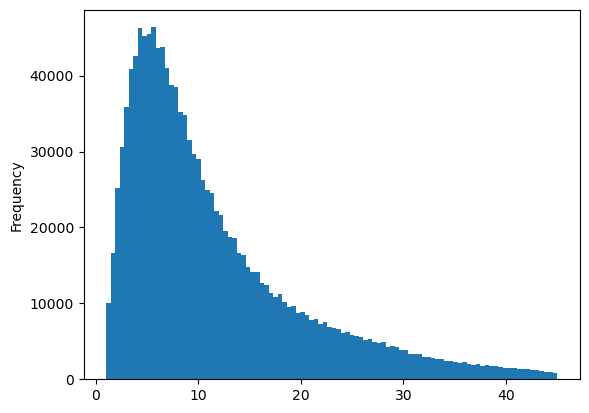

In [17]:
df_shorter = df[df.tripduration/60 <= 45]['tripduration']/60
df_shorter.plot.hist(bins=100)

### 11. What is the median beeline distance travelled

In [18]:
# First caluclate the distance from the coordinates
def calculate_distance_from_coordinates(df:pd.DataFrame, start_lat:str, start_lon:str, end_lat:str, end_lon:str):
    '''
    Function to calculate distances from WGS84 coordinate-pairs.
    :param df: Input Dataframe
    :param start_lat: Latitude of start position
    :param start_lon: Longitude of start position
    :param end_lat: Latitude of end position
    :param end_lon: Longitude of end position
    :return: Input dataframe with a column 'distance' indicating the distane in meters
    '''

    # Calculate distance in KM
    df['distance'] = df.apply(lambda row: geodesic((row[start_lat], row[start_lon]), (row[end_lat], row[end_lon])), axis=1)

    # Remove unit and cast to float and multiply by 1000 to get meters
    df['distance']=df['distance'].astype(str).str[:-3].astype(float)
    df['distance'] = df['distance']*1000

    return df

# Call Function and print median
df = calculate_distance_from_coordinates(
    df=df,
    start_lat='start_station_latitude',
    start_lon='start_station_longitude',
    end_lat='end_station_latitude',
    end_lon='end_station_longitude')


print(f'{df.distance.median()} meters')

1299.9714521791336 meters


### 12. Generate a sub-sample containing a random 10% of the data, and for that subsample plot the time to ride the (beeline) distance.

Text(0.5, 0, 'Beeline distance [m]')

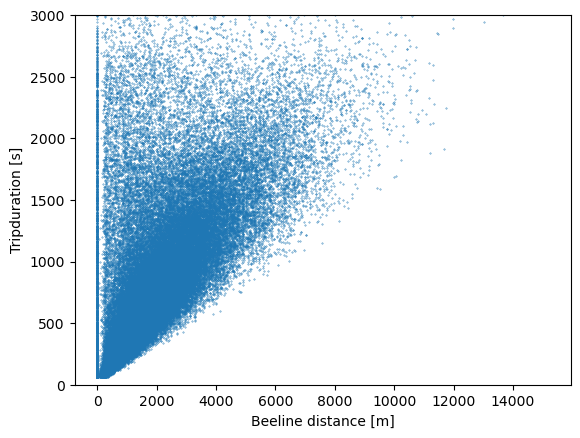

In [29]:
# Get a random 10% subsample and plot it in an appropriate y-range
df_subset = df[['distance', 'tripduration']].sample(frac=0.1)

ax = df_subset.plot.scatter(x='distance', y='tripduration',s=0.1)
ax.set_ylim(0,3000)
plt.ylabel("Tripduration [s]")
plt.xlabel("Beeline distance [m]")

### 13. Plot a map indicating the 10 most and least active stations.


In [ ]:
# First get an activity measure: Number of occurences of the station in start or stop

# Make a dataframe 'stations' containing all stations and their geometries
start_stations = df[['start_station_id', 'start_station_longitude', 'start_station_latitude']]
end_stations =df[['end_station_id', 'end_station_longitude', 'end_station_latitude']]

start_stations.rename(columns={'start_station_id':'station_id', 'start_station longitude':'lon', 'start_station_latitude':'lat'}, inplace=True)
end_stations.rename(columns={'end_station_id':'station_id', 'end_station_longitude':'lon', 'end_station_latitude':'lat'}, inplace=True)

stations = pd.concat([start_stations, end_stations])


# Count the occurence of the stations
stations_count = stations.groupby(['station_id', 'lon', 'lat']).size().to_frame('activity').reset_index()

# Get the stations with the 10 smallest and 10 largest counts
stations_active = stations_count.nsmallest(10, 'activity')
stations_active = pd.concat([stations_active, stations_count.nlargest(10, 'activity')])


# Create a geodataframe
gdf = gpd.GeoDataFrame(
    stations_active, geometry=gpd.points_from_xy(stations_active.lon, stations_active.lat))
gdf = gdf.set_crs('epsg:4326')
gdf = gdf.to_crs(3857)

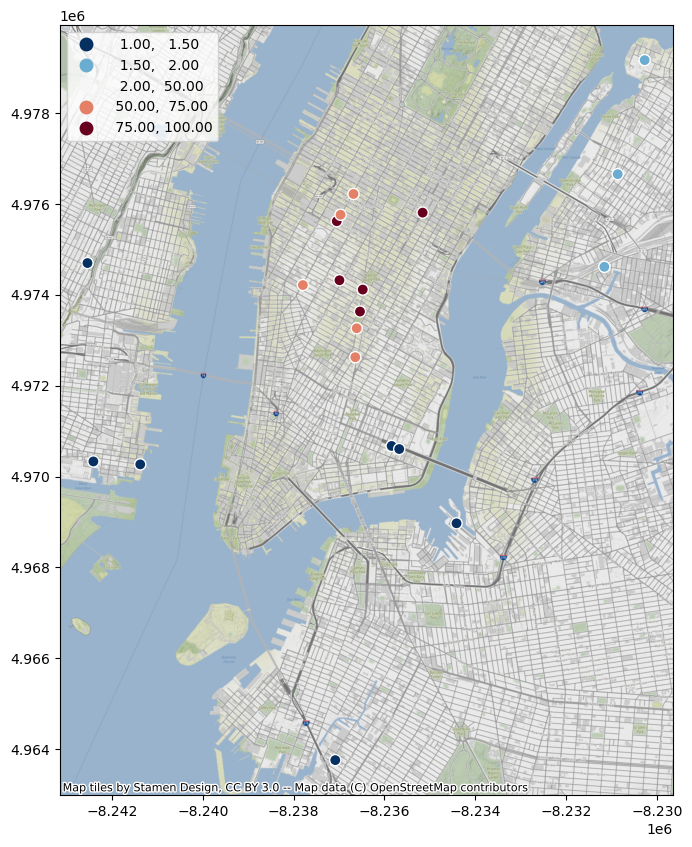

In [68]:
# Plot the points on a New-York basemap
gdf.activity = minmax_scale(gdf.activity, feature_range=(1,100))

fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(
    column = 'activity',
    categorical =True,
    alpha=1,
    ax=ax,
    legend=True,
    markersize =65,
    marker='o',
    cmap='RdBu_r',
    scheme='UserDefined',
    classification_kwds={'bins':[1.5, 2, 50,75, 100]}, edgecolor='white')

cx.add_basemap(ax, zoom=15)

# I chose to color the points according to their activity. They are more visible this way, but the legend is kinda confusing, as there are no values between 2-50.